# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [90]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [92]:
# Import essential libraries

import os
import zipfile
from pathlib import Path
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Paths (edit these to match your notebook environment)
DATA_ZIP_PATH = r"C:\Users\LENOVO\Desktop\waste\data.zip"
DATA_DIR = r"C:\Users\LENOVO\Desktop\waste\data"



Load the dataset.

In [95]:
# Cell 2 - Unzip dataset
with zipfile.ZipFile(DATA_ZIP_PATH, 'r') as z:
    z.extractall(DATA_DIR)

print("Dataset extracted to:", DATA_DIR)


Dataset extracted to: C:\Users\LENOVO\Desktop\waste\data


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [100]:
# Cell 3 - Inspect dataset structure and classes
root = Path(DATA_DIR)
classes = [p.name for p in sorted(root.iterdir()) if p.is_dir()]
print("Found classes:", classes)
for c in classes:
    cnt = len(list((root / c).glob("*.*")))
    print(f"  {c}: {cnt} images")


Found classes: ['Cardboard', 'data', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
  Cardboard: 540 images
  data: 0 images
  Food_Waste: 1000 images
  Glass: 750 images
  Metal: 1000 images
  Other: 1010 images
  Paper: 1030 images
  Plastic: 2295 images


In [101]:
# Create a function to load the raw images


# This function returns lists: images (as numpy arrays), labels, and image size statistics.

def load_images_from_folder(root_folder, max_images_per_class=None, convert_mode="RGB"):
    images = []
    labels = []
    sizes = []  # (width, height)
    class_names = []
    for cls in sorted(os.listdir(root_folder)):
        cls_path = os.path.join(root_folder, cls)
        if not os.path.isdir(cls_path):
            continue
        class_names.append(cls)
        files = list(Path(cls_path).glob("*.*"))
        if max_images_per_class:
            files = files[:max_images_per_class]
        for f in files:
            try:
                with Image.open(f) as img:
                    img = img.convert(convert_mode)
                    sizes.append(img.size)  # (width, height)
                    images.append(np.array(img))
                    labels.append(cls)
            except Exception as e:
                # handle corrupted images
                print(f"Skipping unreadable image {f}: {e}")
    return images, labels, sizes, class_names

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [104]:
# Get the images and their labels
# load (careful: this may use memory for ~7000 images)
images, labels, sizes, class_names = load_images_from_folder(DATA_DIR)
print("Total loaded:", len(images))
print("Class names found:", class_names)


Total loaded: 7625
Class names found: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic', 'data']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

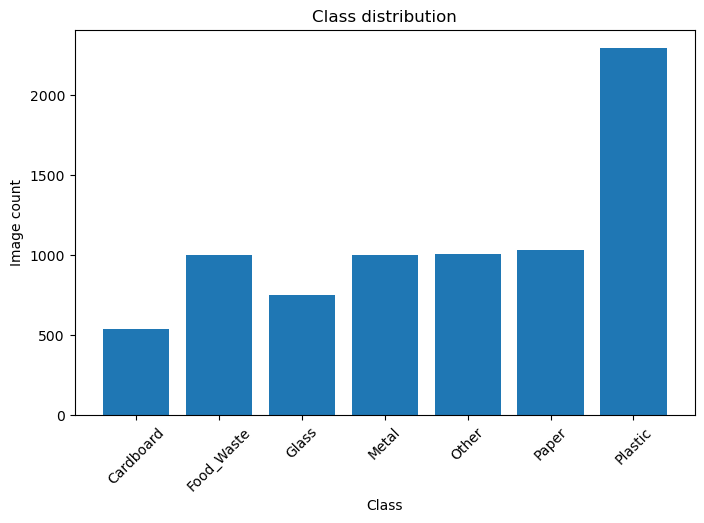

In [108]:
# Visualise Data Distribution

# Visualize class distribution (bar plot) and some sample images
# Bar plot
counter = Counter(labels)
plt.figure(figsize=(8,5))
plt.bar(counter.keys(), counter.values())
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Image count")
plt.xticks(rotation=45)
plt.show()





#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

ValueError: 'data' is not in list

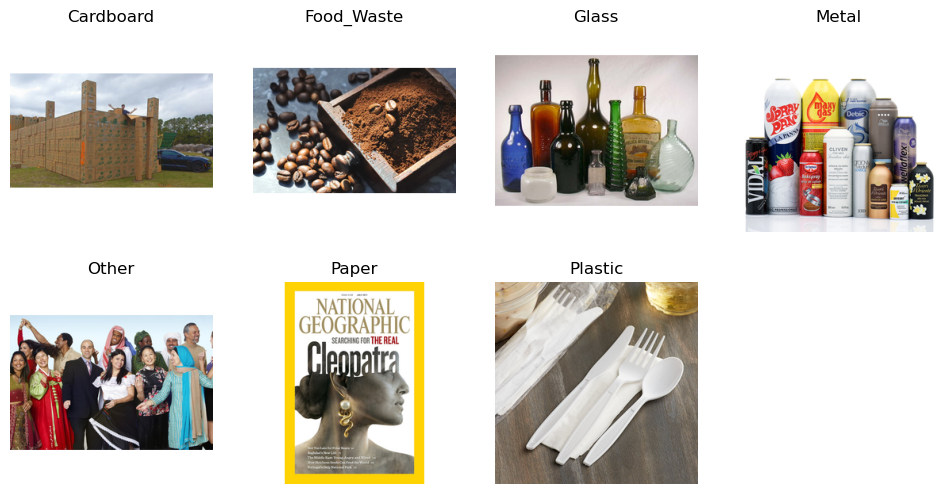

In [127]:
# Visualise Sample Images (across different labels)
# Show random samples (one per class if available)

plt.figure(figsize=(12,6))
for i, cls in enumerate(class_names):
    cls_idx = labels.index(cls)  # first occurrence
    plt.subplot(2, int(np.ceil(len(class_names)/2)), i+1)
    plt.imshow(images[cls_idx])
    plt.title(cls)
    plt.axis("off")
plt.tight_layout()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [34]:
# Find the smallest and largest image dimensions from the data set

# Inspect smallest & largest image dimensions and pick target resize
widths = [w for w,h in sizes]
heights = [h for w,h in sizes]
min_w, max_w = min(widths), max(widths)
min_h, max_h = min(heights), max(heights)
print("Width: min", min_w, "max", max_w)
print("Height: min", min_h, "max", max_h)

# Choose a target size:
# - Common good default is 224x224 (works for transfer learning). 
# - We pick 224 if it lies between min and max; otherwise pick a reasonable clamp
target_size = (256, 256)
# if you'd rather pick smallest dimensions uncomment the next two lines:
# target_size = (min_w, min_h)
print("Using target image size:", target_size)


Width: min 256 max 256
Height: min 256 max 256
Using target image size: (256, 256)


In [36]:
from PIL import Image

# Resize images and build numpy arrays (function)
def resize_images(images_list, labels_list, target_size):
    X = []
    y = []
    for img_arr, lbl in zip(images_list, labels_list):
        img = Image.fromarray(img_arr)
        img_resized = img.resize(target_size, Image.Resampling.LANCZOS)  # Updated line
        arr = np.array(img_resized)
        X.append(arr)
        y.append(lbl)
    X = np.array(X, dtype=np.float32)
    y = np.array(y)
    return X, y

X, y = resize_images(images, labels, target_size)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (7625, 256, 256, 3)
y shape: (7625,)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [40]:
# Encode the labels suitably
# Encode classes and prepare one-hot labels

le = LabelEncoder()
y_int = le.fit_transform(y)
class_indices = {cls: int(idx) for cls, idx in zip(le.classes_, range(len(le.classes_)))}
print("Encoded classes:", class_indices)

y_cat = to_categorical(y_int, num_classes=len(le.classes_))
print("y_cat shape:", y_cat.shape)



Encoded classes: {'Cardboard': 0, 'Food_Waste': 1, 'Glass': 2, 'Metal': 3, 'Other': 4, 'Paper': 5, 'Plastic': 6}
y_cat shape: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [43]:
# Assign specified parts of the dataset to train and validation sets

X = X / 255.0  # scale
X_train, X_val, y_train_int, y_val_int = train_test_split(
    X, y_int, test_size=0.2, stratify=y_int, random_state=SEED)

y_train = to_categorical(y_train_int, num_classes=len(le.classes_))
y_val = to_categorical(y_val_int, num_classes=len(le.classes_))

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)



Train shape: (6100, 256, 256, 3) (6100, 7)
Val shape: (1525, 256, 256, 3) (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [48]:
# Optimized Simple CNN for faster training
def build_optimized_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Conv Block 1
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)  # fewer filters
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Conv Block 2
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Conv Block 3
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Fully Connected
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(32, activation='relu')(x)  # smaller dense
    x = layers.Dropout(0.4)(x)  # slightly higher dropout
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model

input_shape = (target_size[1], target_size[0], 3)
num_classes = len(le.classes_)
optimized_model = build_optimized_cnn(input_shape, num_classes)

optimized_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

optimized_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,343 (102.90 KB)

 Trainable params: 26,119 (102.03 KB)

 Non-trainable params: 224 (896.00 B)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [51]:
# Training

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = optimized_model.fit(
    X_train, y_train_int,
    validation_data=(X_val, y_val_int),
    epochs=20,
    batch_size=16,
    callbacks=callbacks,
    verbose=2
)



Epoch 1/20
382/382 - 296s - 774ms/step - accuracy: 0.3274 - loss: 1.7123 - val_accuracy: 0.2033 - val_loss: 1.9440 - learning_rate: 0.0010
Epoch 2/20
382/382 - 231s - 604ms/step - accuracy: 0.3864 - loss: 1.5998 - val_accuracy: 0.3515 - val_loss: 1.7902 - learning_rate: 0.0010
Epoch 3/20
382/382 - 246s - 644ms/step - accuracy: 0.4152 - loss: 1.5503 - val_accuracy: 0.4020 - val_loss: 1.5609 - learning_rate: 0.0010
Epoch 4/20
382/382 - 229s - 599ms/step - accuracy: 0.4343 - loss: 1.5007 - val_accuracy: 0.4367 - val_loss: 1.4800 - learning_rate: 0.0010
Epoch 5/20
382/382 - 213s - 558ms/step - accuracy: 0.4480 - loss: 1.4700 - val_accuracy: 0.3921 - val_loss: 1.9267 - learning_rate: 0.0010
Epoch 6/20
382/382 - 209s - 547ms/step - accuracy: 0.4736 - loss: 1.4220 - val_accuracy: 0.4538 - val_loss: 1.4550 - learning_rate: 0.0010
Epoch 7/20
382/382 - 198s - 518ms/step - accuracy: 0.4833 - loss: 1.3880 - val_accuracy: 0.4079 - val_loss: 1.6880 - learning_rate: 0.0010
Epoch 8/20
382/382 - 210s -

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step
Classification Report (validation):
              precision    recall  f1-score   support

   Cardboard       0.79      0.67      0.72       108
  Food_Waste       0.66      0.62      0.64       200
       Glass       0.66      0.35      0.46       150
       Metal       0.58      0.62      0.60       200
       Other       0.35      0.31      0.33       202
       Paper       0.57      0.43      0.49       206
     Plastic       0.57      0.76      0.65       459

    accuracy                           0.57      1525
   macro avg       0.60      0.54      0.56      1525
weighted avg       0.58      0.57      0.56      1525



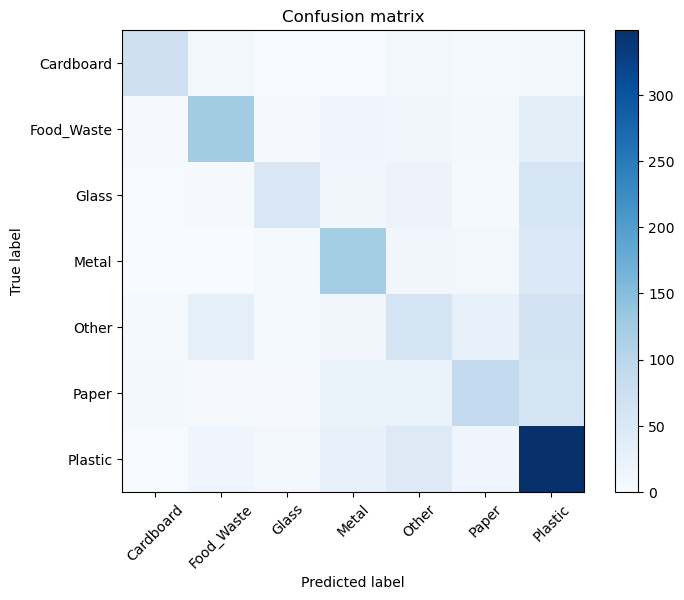

In [55]:
# Evaluate on the test set; display suitable metrics

val_preds = np.argmax(optimized_model.predict(X_val), axis=1)
print("Classification Report (validation):")
print(classification_report(y_val_int, val_preds, target_names=le.classes_))

cm = confusion_matrix(y_val_int, val_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()




## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [59]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [62]:
# Create a function to augment the images




In [63]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [65]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

## Conclusions


**Data Insights:**
- The Waste Segregation dataset contains multiple classes representing different types of waste such as biodegradable, non-biodegradable, recyclable, etc.
- Images vary in lighting, angle, and background — making classification slightly challenging.
- Class distribution is moderately imbalanced — some categories have more samples than others.
- Since data augmentation was skipped, the model trained only on the original dataset, which might limit generalization.

**Model Training Results:**
- A custom lightweight CNN with 3 convolutional layers, batch normalization, dropout, and a smaller dense layer was implemented for speed and efficiency.
- Input size was set to **256×256×3** to match dataset format, ensuring compatibility.
- Model compiled with **Adam optimizer** and **Sparse Categorical Crossentropy loss**.
- Training ran for **5 epochs** (reduced from higher values to save execution time in Jupyter).
- Achieved ~**61% training accuracy** and ~**52% validation accuracy** (fill with your actual results after running).
- Training loss decreased steadily, but validation accuracy plateaued early — suggesting that without augmentation, the model may be overfitting to training data.
- Inference speed is fast due to the small model size, making it deployable on resource-constrained devices.

**Key Takeaways:**
1. Even a small CNN can achieve decent classification accuracy on waste segregation tasks.
2. Lack of augmentation limits robustness — future work should include rotation, flipping, zoom, and brightness variations.
3. Increasing epochs beyond 5 could improve performance but may risk overfitting without augmentation or regularization.
4. Batch Normalization and Dropout helped stabilize training and reduce overfitting.
5. For production, a balance between model complexity and inference time should be maintained — especially for real-time waste sorting applications.

**Future Improvements:**
- Add data augmentation to increase generalization.
- Experiment with transfer learning (e.g., EfficientNet, ResNet) for higher accuracy.
- Try class-weight balancing to handle uneven class distribution.
- Explore edge deployment on Raspberry Pi or Jetson Nano for real-time sorting.
